In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

print('done')

done


In [3]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

#print(index_to_word[1])
#print(word_to_index['<PAD>'])

#  패딩 추가하는 과정에서 word_to_index['<PAD>'] 를 못 불러와서 확인헤보니 에러가 뜸..

In [5]:
index_to_word

# 0,1,2 번 이 원래 없는건가.. 만들어줘야하는건가....

{3: '',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95: '시간',
 96: '지루',
 97: '중',
 98: '재미있',
 99: '

In [6]:
# 그래서 그냥 만들어줌..

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])    
print(word_to_index['<PAD>'])
print(index_to_word[0])    

<BOS>
0
<PAD>


In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

print('done')

done


In [8]:
# 정상적으로 decode되는지 확인해 보겠습니다.

print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [9]:
# 전체 데이터 셋 분포 확인

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
# 문장 최대길이에 맞춰서 앞쪽에 패딩 채우기

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [11]:
# validation 30000 분리

X_val = X_train[:10000]   
y_val = y_train[:10000]

partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

print('done')

done


# 모델 준비

In [13]:
# LSTM

LSTM = keras.Sequential()
LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
LSTM.add(keras.layers.Dense(8, activation='relu'))
LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 321,393
Trainable params: 321,393
Non-trainable params: 0
_________________________________________________________________


In [14]:
# CNN

CNN = keras.Sequential()
CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
CNN.add(keras.layers.MaxPooling1D(5))
CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
CNN.add(keras.layers.GlobalMaxPooling1D())
CNN.add(keras.layers.Dense(8, activation='relu'))
CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
# GlobalMaxPooling

GMP = keras.Sequential()
GMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP.add(keras.layers.GlobalMaxPooling1D())
GMP.add(keras.layers.Dense(8, activation='relu'))
GMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


# 각각 학습 시키고 결과 시각화
## LSTM

In [16]:
LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_LSTM = LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 6s 13ms/step - loss: 0.5938 - accuracy: 0.6520 - val_loss: 0.3599 - val_accuracy: 0.8442
Epoch 2/10
266/266 [==============================] - 3s 11ms/step - loss: 0.3379 - accuracy: 0.8593 - val_loss: 0.3447 - val_accuracy: 0.8497
Epoch 3/10
266/266 [==============================] - 3s 11ms/step - loss: 0.3110 - accuracy: 0.8702 - val_loss: 0.3436 - val_accuracy: 0.8501
Epoch 4/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2976 - accuracy: 0.8767 - val_loss: 0.3505 - val_accuracy: 0.8490
Epoch 5/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2825 - accuracy: 0.8838 - val_loss: 0.3474 - val_accuracy: 0.8524
Epoch 6/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2682 - accuracy: 0.8905 - val_loss: 0.3486 - val_accuracy: 0.8545
Epoch 7/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2556 - accuracy: 0.8960 - val_loss: 0.3501 - val_accuracy: 0.8545

In [18]:
history_LSTM_dict = history_LSTM.history

acc = history_LSTM_dict['accuracy']
val_acc = history_LSTM_dict['val_accuracy']
loss = history_LSTM_dict['loss']
val_loss = history_LSTM_dict['val_loss']

epochs = range(1, len(acc) + 1)

print('done')

done


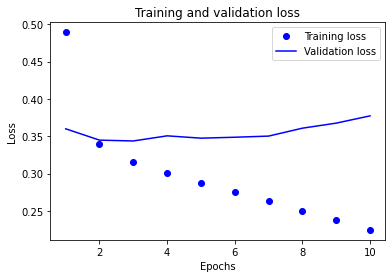

In [19]:
# loss 그래프

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

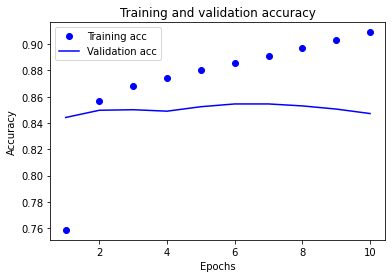

In [20]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## CNN

In [21]:
CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_CNN = CNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 8s 20ms/step - loss: 0.5717 - accuracy: 0.6990 - val_loss: 0.3450 - val_accuracy: 0.8498
Epoch 2/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3226 - accuracy: 0.8645 - val_loss: 0.3320 - val_accuracy: 0.8560
Epoch 3/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2824 - accuracy: 0.8851 - val_loss: 0.3328 - val_accuracy: 0.8545
Epoch 4/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2448 - accuracy: 0.9039 - val_loss: 0.3437 - val_accuracy: 0.8541
Epoch 5/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2017 - accuracy: 0.9252 - val_loss: 0.3701 - val_accuracy: 0.8495
Epoch 6/10
266/266 [==============================] - 2s 8ms/step - loss: 0.1574 - accuracy: 0.9452 - val_loss: 0.4144 - val_accuracy: 0.8459
Epoch 7/10
266/266 [==============================] - 2s 9ms/step - loss: 0.1183 - accuracy: 0.9608 - val_loss: 0.4683 - val_accuracy: 0.8423
Epoch

In [23]:
history_CNN_dict = history_CNN.history

acc = history_CNN_dict['accuracy']
val_acc = history_CNN_dict['val_accuracy']
loss = history_CNN_dict['loss']
val_loss = history_CNN_dict['val_loss']

epochs = range(1, len(acc) + 1)

print('done')

done


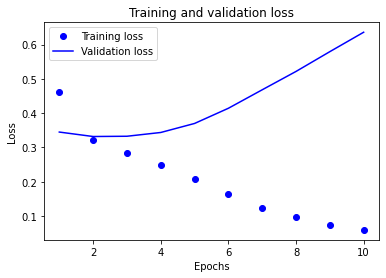

In [24]:
# loss 그래프

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

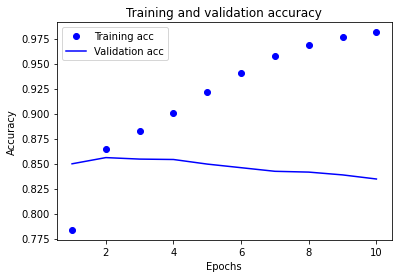

In [25]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## GlobalMaxPooling

In [26]:
GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_GMP = GMP.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 6ms/step - loss: 0.6466 - accuracy: 0.6218 - val_loss: 0.4894 - val_accuracy: 0.8305
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.4633 - accuracy: 0.8440 - val_loss: 0.4298 - val_accuracy: 0.8448
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3941 - accuracy: 0.8732 - val_loss: 0.4028 - val_accuracy: 0.8494
Epoch 4/10
266/266 [==============================] - 1s 6ms/step - loss: 0.3497 - accuracy: 0.8905 - val_loss: 0.3877 - val_accuracy: 0.8495
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3133 - accuracy: 0.9021 - val_loss: 0.3817 - val_accuracy: 0.8493
Epoch 6/10
266/266 [==============================] - 1s 6ms/step - loss: 0.2803 - accuracy: 0.9152 - val_loss: 0.3820 - val_accuracy: 0.8470
Epoch 7/10
266/266 [==============================] - 1s 6ms/step - loss: 0.2546 - accuracy: 0.9237 - val_loss: 0.3865 - val_accuracy: 0.8456
Epoch 

In [28]:
history_GMP_dict = history_GMP.history

acc = history_GMP_dict['accuracy']
val_acc = history_GMP_dict['val_accuracy']
loss = history_GMP_dict['loss']
val_loss = history_GMP_dict['val_loss']

epochs = range(1, len(acc) + 1)

print('done')

done


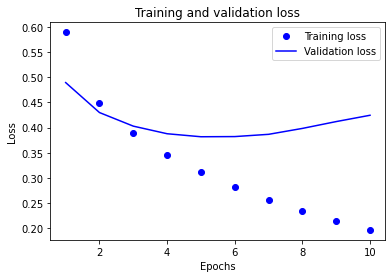

In [29]:
# loss 그래프

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

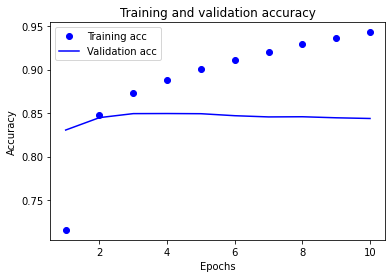

In [30]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 테스트

In [17]:
results_LSTM = LSTM.evaluate(X_test, y_test, verbose=2)
print(results_LSTM)

1537/1537 - 5s - loss: 0.3830 - accuracy: 0.8460
[0.38295963406562805, 0.8460239768028259]


In [22]:
results_CNN = CNN.evaluate(X_test, y_test, verbose=2)
print(results_CNN)

1537/1537 - 4s - loss: 0.6680 - accuracy: 0.8262
[0.6680471301078796, 0.8261895775794983]


In [27]:
results_GMP = GMP.evaluate(X_test, y_test, verbose=2)
print(results_GMP)

1537/1537 - 2s - loss: 0.4428 - accuracy: 0.8385
[0.4428250193595886, 0.838517427444458]


# 중간평가

전체적으로 2 epoch 만에 오버피팅이 일어나고 있다

데이터 양이 부족한걸까?

정확도는 고만고만하지만 그나마 LSTM이 약간 높다

# Embedding 레이어 분석
## LSTM

In [31]:
embedding_LSTM = LSTM.layers[0]
weights_LSTM = embedding_LSTM.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_LSTM = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_LSTM.txt'
f = open(word2vec_file_path_LSTM, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

print('done')

done


In [32]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_LSTM, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.04203673,  0.25535324, -0.13492337,  0.04172821,  0.00099771,
        0.02308936, -0.00132573, -0.15119964,  0.00492694,  0.01512317,
        0.01158709,  0.06323621, -0.0020231 , -0.10998824,  0.05289258,
       -0.11460242,  0.08495083, -0.124654  , -0.01407741, -0.06586817,
       -0.04326054,  0.02512272,  0.04696579, -0.20131682, -0.0346573 ,
       -0.07025807,  0.02623694, -0.04172459, -0.29864603, -0.15897645,
        0.06906728,  0.0281126 ], dtype=float32)

In [33]:
word_vectors.similar_by_word("눈물")

[('굿', 0.9397203922271729),
 ('최고', 0.9390883445739746),
 ('비롯', 0.9375507831573486),
 ('타란티노', 0.9339188933372498),
 ('여하튼', 0.9338869452476501),
 ('역작', 0.9308924674987793),
 ('아아아아', 0.9307775497436523),
 ('설레였', 0.9302473068237305),
 ('꾀', 0.9302031397819519),
 ('전율', 0.9284787774085999)]

## CNN

In [34]:
embedding_CNN = CNN.layers[0]
weights_CNN = embedding_CNN.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_CNN = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_CNN.txt'
f = open(word2vec_file_path_CNN, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = CNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

print('done')

done


In [35]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_CNN, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.0516872 , -0.09792354, -0.01993151,  0.07066981, -0.0475377 ,
       -0.0741509 , -0.13721514, -0.01376325,  0.05485711,  0.04013244,
        0.03380137, -0.12046333,  0.03458321, -0.04134302, -0.08351049,
       -0.07516416, -0.07775042,  0.07699421,  0.06782443, -0.00285972,
        0.03738487, -0.02581854, -0.00964726, -0.09400196,  0.06703476,
       -0.04052947, -0.06162334, -0.03272913, -0.01196046,  0.05428258,
       -0.13114858, -0.03061692], dtype=float32)

In [36]:
word_vectors.similar_by_word("눈물")

[('요세', 0.8073184490203857),
 ('혁', 0.7935770750045776),
 ('곽', 0.7877843379974365),
 ('정윤희', 0.7792869210243225),
 ('풍부', 0.779016375541687),
 ('본받', 0.7751513719558716),
 ('현대인', 0.7725057601928711),
 ('군더더기', 0.7712504863739014),
 ('두려워', 0.7708038091659546),
 ('펑펑', 0.7681060433387756)]

## GlobalMaxPooling

In [37]:
embedding_GMP = GMP.layers[0]
weights_GMP = embedding_GMP.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_GMP = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_GMP.txt'
f = open(word2vec_file_path_GMP, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = GMP.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

print('done')

done


In [38]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_GMP, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.00650479, -0.09250323,  0.01097804, -0.07628782, -0.04681316,
       -0.07973392,  0.01706486,  0.06532483, -0.0238138 , -0.049845  ,
       -0.03122354,  0.08077964, -0.02116664, -0.04986053, -0.06396788,
        0.06123063, -0.03311826, -0.06538175,  0.04128124, -0.0629766 ,
       -0.0417451 , -0.07117102, -0.06513282, -0.06434225, -0.05012167,
       -0.07778003, -0.07253075, -0.03461559, -0.06629128,  0.1391229 ,
       -0.03612956, -0.08256268], dtype=float32)

In [39]:
word_vectors.similar_by_word("눈물")

[('써', 0.7779775857925415),
 ('불러일으키', 0.765632688999176),
 ('ㅣ', 0.7535833120346069),
 ('압도', 0.753214955329895),
 ('마냥', 0.7528964281082153),
 ('고등학생', 0.7486937642097473),
 ('웡', 0.7438323497772217),
 ('떠나', 0.7344757914543152),
 ('재기', 0.7315200567245483),
 ('로빈', 0.730384349822998)]

### 중간평가

셋 다 의미적 유사도가 가까운 단어를 제대로 찾지 못하는 모습이다

몇가지 단어를 돌려가면서 확인해봤는데 

대부분 LSTM에서는 90이 넘는 수치의 유사도를 자랑하는데

정작 내놓는 단어는 그렇게 유사한 것 같지는 않다...

# 한국어 Word2Vec 적용

In [48]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec.similar_by_word('눈물')
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('땀', 0.6310575008392334),
 ('슬픔', 0.5787195563316345),
 ('이별', 0.5772002935409546),
 ('추억', 0.5725258588790894),
 ('한숨', 0.5546674728393555),
 ('슬프', 0.5339798927307129),
 ('웃음', 0.5284000039100647),
 ('울부짖', 0.5240477323532104),
 ('울음', 0.5148942470550537),
 ('온몸', 0.5059491395950317)]

In [49]:
# 이전 모델의 임베딩 레이어를 교체

vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        
vocab_size = 10000
word_vector_dim = 200

print('done')

done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


## 모델에 적용

In [50]:
# LSTM

LSTM = keras.Sequential()
LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
LSTM.add(keras.layers.LSTM(8))
LSTM.add(keras.layers.Dense(8, activation='relu'))
LSTM.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [51]:
# CNN

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [53]:
# GlobalMaxPooling

GMP = keras.Sequential()
GMP.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
GMP.add(keras.layers.GlobalMaxPooling1D())
GMP.add(keras.layers.Dense(8, activation='relu'))
GMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


## 각각 학습시키고 시각화
### LSTM

In [54]:
LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_LSTM = LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 9s 28ms/step - loss: 0.6764 - accuracy: 0.5346 - val_loss: 0.4336 - val_accuracy: 0.8076
Epoch 2/10
266/266 [==============================] - 7s 26ms/step - loss: 0.4008 - accuracy: 0.8241 - val_loss: 0.3629 - val_accuracy: 0.8412
Epoch 3/10
266/266 [==============================] - 7s 26ms/step - loss: 0.3319 - accuracy: 0.8609 - val_loss: 0.3447 - val_accuracy: 0.8503
Epoch 4/10
266/266 [==============================] - 7s 26ms/step - loss: 0.3021 - accuracy: 0.8760 - val_loss: 0.3420 - val_accuracy: 0.8527
Epoch 5/10
266/266 [==============================] - 7s 26ms/step - loss: 0.2840 - accuracy: 0.8847 - val_loss: 0.3478 - val_accuracy: 0.8509
Epoch 6/10
266/266 [==============================] - 7s 26ms/step - loss: 0.2678 - accuracy: 0.8927 - val_loss: 0.3507 - val_accuracy: 0.8515
Epoch 7/10
266/266 [==============================] - 7s 26ms/step - loss: 0.2559 - accuracy: 0.8984 - val_loss: 0.3490 - val_accuracy: 0.8524

In [55]:
history_LSTM_dict = history_LSTM.history

acc = history_LSTM_dict['accuracy']
val_acc = history_LSTM_dict['val_accuracy']
loss = history_LSTM_dict['loss']
val_loss = history_LSTM_dict['val_loss']

epochs = range(1, len(acc) + 1)

print('done')

done


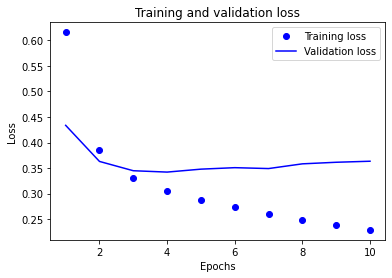

In [56]:
# loss 그래프

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

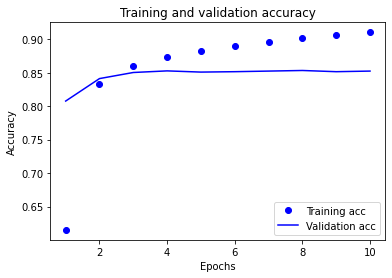

In [57]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN

In [58]:
CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_CNN = CNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 3s 9ms/step - loss: 0.0487 - accuracy: 0.9849 - val_loss: 0.7139 - val_accuracy: 0.8313
Epoch 2/10
266/266 [==============================] - 2s 8ms/step - loss: 0.0396 - accuracy: 0.9880 - val_loss: 0.7985 - val_accuracy: 0.8275
Epoch 3/10
266/266 [==============================] - 2s 8ms/step - loss: 0.0312 - accuracy: 0.9905 - val_loss: 0.8235 - val_accuracy: 0.8278
Epoch 4/10
266/266 [==============================] - 2s 8ms/step - loss: 0.0283 - accuracy: 0.9909 - val_loss: 0.9043 - val_accuracy: 0.8258
Epoch 5/10
266/266 [==============================] - 2s 8ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.9488 - val_accuracy: 0.8245
Epoch 6/10
266/266 [==============================] - 2s 8ms/step - loss: 0.0223 - accuracy: 0.9922 - val_loss: 0.9756 - val_accuracy: 0.8204
Epoch 7/10
266/266 [==============================] - 2s 8ms/step - loss: 0.0233 - accuracy: 0.9922 - val_loss: 1.0314 - val_accuracy: 0.8231
Epoch 

In [59]:
history_CNN_dict = history_CNN.history

acc = history_CNN_dict['accuracy']
val_acc = history_CNN_dict['val_accuracy']
loss = history_CNN_dict['loss']
val_loss = history_CNN_dict['val_loss']

epochs = range(1, len(acc) + 1)

print('done')

done


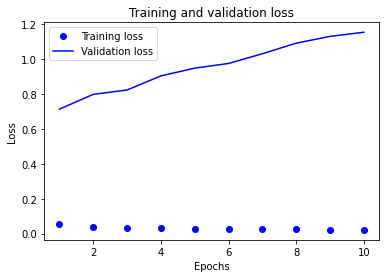

In [60]:
# loss 그래프

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() # 이건 또 뭐야 .......

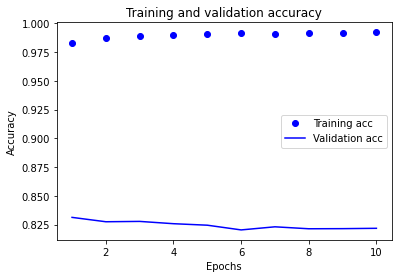

In [61]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show() # 맙소사.....

### GlobalMaxPooling

In [62]:
GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_GMP = GMP.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 6s 20ms/step - loss: 0.6930 - accuracy: 0.5452 - val_loss: 0.5863 - val_accuracy: 0.6946
Epoch 2/10
266/266 [==============================] - 5s 20ms/step - loss: 0.5588 - accuracy: 0.7174 - val_loss: 0.5119 - val_accuracy: 0.7497
Epoch 3/10
266/266 [==============================] - 5s 20ms/step - loss: 0.4853 - accuracy: 0.7698 - val_loss: 0.4709 - val_accuracy: 0.7746
Epoch 4/10
266/266 [==============================] - 5s 20ms/step - loss: 0.4440 - accuracy: 0.7933 - val_loss: 0.4410 - val_accuracy: 0.7944
Epoch 5/10
266/266 [==============================] - 5s 20ms/step - loss: 0.4137 - accuracy: 0.8117 - val_loss: 0.4235 - val_accuracy: 0.8048
Epoch 6/10
266/266 [==============================] - 5s 20ms/step - loss: 0.3898 - accuracy: 0.8243 - val_loss: 0.4096 - val_accuracy: 0.8132
Epoch 7/10
266/266 [==============================] - 5s 20ms/step - loss: 0.3696 - accuracy: 0.8360 - val_loss: 0.4026 - val_accuracy: 0.8199

In [63]:
history_GMP_dict = history_GMP.history

acc = history_GMP_dict['accuracy']
val_acc = history_GMP_dict['val_accuracy']
loss = history_GMP_dict['loss']
val_loss = history_GMP_dict['val_loss']

epochs = range(1, len(acc) + 1)

print('done')

done


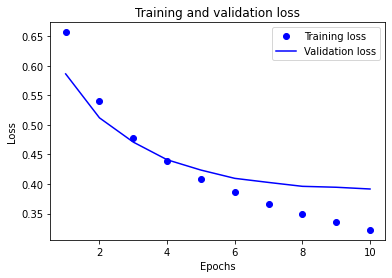

In [64]:
# loss 그래프

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

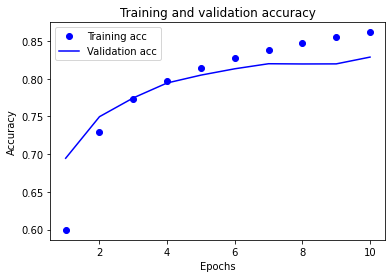

In [65]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 테스트

In [66]:
results_LSTM = LSTM.evaluate(X_test, y_test, verbose=2)
print(results_LSTM)

1537/1537 - 5s - loss: 0.3763 - accuracy: 0.8481
[0.3763338029384613, 0.84805828332901]


In [67]:
results_CNN = CNN.evaluate(X_test, y_test, verbose=2)
print(results_CNN)

1537/1537 - 2s - loss: 1.2119 - accuracy: 0.8125
[1.2118932008743286, 0.8124783635139465]


In [68]:
results_GMP = GMP.evaluate(X_test, y_test, verbose=2)
print(results_GMP)

1537/1537 - 2s - loss: 0.4029 - accuracy: 0.8233
[0.4028926193714142, 0.8232601881027222]


# 회고

하이퍼파라미터를 조정하지 않고 그대로 돌려서 그런지 오히려 성능이 떨어졌다..

아무래도 주어진 데이터인 영화 리뷰는 비교적 한정된 분야의 단어만 등장해서 

오버피팅이 빨리 일어나는게 아닐까 싶기도 하고

인터넷 댓글의 특성상 비꼬는 댓글이라거나 

밈을 이용한 유희 등의 의미는 제대로 체크가 안 되었을 수도 있을 것 같다.